# PREDICTING VANCOUVER WEATHER PROJECT REPORT

## Introduction
*** intro here ***


## Methods

We will use the temperature (Celsius), feels-like temperature (Celsius), humidity (g/m^3), cloud cover (%), sea level pressure, and the wind speed (km/h) in order to determine the expected weather. Before working with the actual data, we are planning to predict the weather type by using common sense. For example, when the temperature is high, the expected precipitation is likely going to be on the lower side. Higher wind speed would indicate the higher precipitation rate. Then, we will use the functions and code that we learned from classification lessons to determine the actual weather type for specific hours in Vancouver. We are planning to create several different scatterplots with different y-axis: temperature, humidity, cloud cover, sea level pressure, and wind speed. The date will be the x-axis and we will categorize each point as its weather type for all graphs.



First, we will load in the necesarry libraries

In [4]:
library(repr)
library(tidyverse)
library(tidymodels)


We will now read our data from the web

In [5]:
weather_data <- read_csv("https://raw.githubusercontent.com/DaffyDiamond/DSCI-100-Group-30/main/data/vancouver_hourly.csv")
head(weather_data, 5)

Rows: 17544 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): name, preciptype, conditions, icon, stations
dbl  (18): temp, feelslike, dew, humidity, precip, precipprob, snow, snowdep...
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,⋯,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
vancouver,2020-12-31 00:00:00,5.9,3.0,5.3,95.97,1.376,100,rain,0,⋯,1005.7,84.6,13,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 01:00:00,5.7,2.9,5.0,95.13,0.191,100,rain,0,⋯,1006.3,100.0,12,0,NA,0,NA,"Rain, Overcast",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 02:00:00,5.8,3.5,4.9,93.72,0.606,100,rain,0,⋯,1007.4,71.2,16,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 03:00:00,5.7,3.7,4.8,94.11,0.108,100,rain,0,⋯,1008.5,80.7,24,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 04:00:00,5.5,3.5,5.1,96.73,2.166,100,rain,0,⋯,1009.6,100.0,6,0,NA,0,NA,"Rain, Overcast",rain,"CWWA,71211099999,71775099999,71784099999,71892099999,71042099999"


Next we clean the data by removing columns and rows that are unnecesarry to our project

In [6]:
# selected out variables that are irrelivant to our predictions
weather_cleaned <- weather_data |>
    select(datetime, temp, feelslike, humidity, sealevelpressure, windspeed, cloudcover, icon) |>
    rename(weather = icon) |>
# wind has been filtered out due to being statistically insignificant
    filter(!(weather == "wind"))

head(weather_cleaned, 5)

datetime,temp,feelslike,humidity,sealevelpressure,windspeed,cloudcover,weather
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2020-12-31 00:00:00,5.9,3.0,95.97,1005.7,14.3,84.6,rain
2020-12-31 01:00:00,5.7,2.9,95.13,1006.3,13.4,100.0,rain
2020-12-31 02:00:00,5.8,3.5,93.72,1007.4,10.7,71.2,rain
2020-12-31 03:00:00,5.7,3.7,94.11,1008.5,9.3,80.7,rain
2020-12-31 04:00:00,5.5,3.5,96.73,1009.6,9.2,100.0,rain


We are now ready to split the data into training and testing to prepare for classification, a seed is used so results can be replicated.

In [9]:
set.seed(1234)

weather_split <- initial_split(weather_cleaned, prop = 0.75, strata = weather)
weather_training <- training(weather_split)
weather_testing <- testing(weather_split)

We will now take a look at the preportions of our data

In [8]:
weather_amount <- weather_training |>
    group_by(weather) |>
    summarize(n())
weather_amount

weather,n()
<chr>,<int>
clear-day,908
clear-night,1190
cloudy,2834
partly-cloudy-day,2890
partly-cloudy-night,2218
rain,2879
snow,233


the proportions of the data appears to be quite unblanced, this means we will have to scale and balance the data in the recipe

In [10]:
weather_recipe <- recipe( weather ~ temp + feelslike + humidity + sealevelpressure + windspeed + cloudcover, data = weather_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

before we start the classification, we must first design the specification, ktune must be used to find the optimal k value.

In [11]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


To find the optimal k value, we will be using 10 fold cross validation to ensure greater accuracy 

In [12]:
weather_vfold <- vfold_cv(weather_training, v = 5, strata = weather)

we will now create the resample workflow to help us find the ideal k value

In [13]:
set.seed(4321)
weather_k_results <- workflow() |>
      add_recipe(weather_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = weather_vfold, grid = 20) |>
      collect_metrics()
weather_k_results


x Fold3: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 2629 or 1, not 2630.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6510176,4,0.0039347685,Preprocessor1_Model01
1,roc_auc,hand_till,0.8044396,4,0.0037700302,Preprocessor1_Model01
2,accuracy,multiclass,0.6510176,4,0.0039347685,Preprocessor1_Model02
2,roc_auc,hand_till,0.8686809,4,0.0038951305,Preprocessor1_Model02
3,accuracy,multiclass,0.6737307,4,0.0033153100,Preprocessor1_Model03
3,roc_auc,hand_till,0.8926436,4,0.0027771057,Preprocessor1_Model03
4,accuracy,multiclass,0.6763924,4,0.0034145417,Preprocessor1_Model04
4,roc_auc,hand_till,0.9068897,4,0.0036739526,Preprocessor1_Model04
5,accuracy,multiclass,0.6857070,4,0.0021744050,Preprocessor1_Model05


after collecting the results, we will use a graph to help us visualize the ideal k value

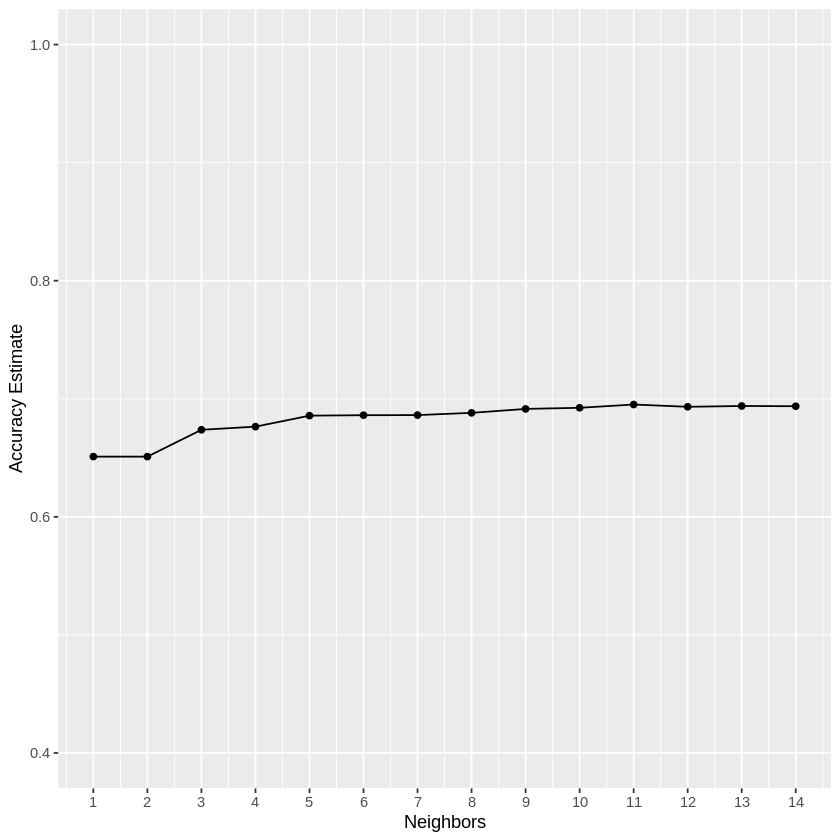

In [14]:
accuracies <- weather_k_results|> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k
# your code here

Now we will use this information to find the ideal k value

In [20]:
kval <- accuracies |>
    arrange(desc(mean)) |>
    head(1)|>
    select(neighbors)|>
    pull()
    
kval

[1] 11

now that we have the ideal k value, we can create the proper knn specification for the classification

In [21]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kval) |>
      set_engine("kknn") |>
      set_mode("classification")

now the we have the specification, we can start to put the whole thing together

In [24]:
set.seed(2222)
weather_fit <- workflow() |>
      add_recipe(weather_recipe) |>
      add_model(knn_spec) |>
      fit(data = weather_training)
weather_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2999011
Best kernel: rectangular
Best k: 11

with our workflow ready to go, we can now dothe classification

In [33]:
set.seed(111) # DO NOT REMOVE

weather_test_predictions <- predict(weather_fit, weather_testing) |>
      bind_cols(weather_testing)|>
      mutate(weather = as.factor(weather))
head(weather_test_predictions, 5)

.pred_class,datetime,temp,feelslike,humidity,sealevelpressure,windspeed,cloudcover,weather
<fct>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
rain,2020-12-31 00:00:00,5.9,3.0,95.97,1005.7,14.3,84.6,rain
rain,2020-12-31 01:00:00,5.7,2.9,95.13,1006.3,13.4,100.0,rain
rain,2020-12-31 03:00:00,5.7,3.7,94.11,1008.5,9.3,80.7,rain
rain,2020-12-31 05:00:00,5.5,5.5,95.33,1011.0,3.4,92.0,rain
rain,2020-12-31 07:00:00,5.0,5.0,97.06,1013.1,1.7,100.0,cloudy


now that we have a set of prediction for our testing set, we can now use the metric function to asses
the accuracy of our classifier

In [35]:
waether_prediction_accuracy <- weather_test_predictions |>
        metrics(truth = weather, estimate = .pred_class)             
waether_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6931145
kap,multiclass,0.6235783


to get a better scope of the accuracy of our classifier, we shall create a confusion matrix

In [38]:
set.seed(3333)
weather_mat <- weather_test_predictions |> 
      conf_mat(truth = weather, estimate = .pred_class)
weather_mat

                     Truth
Prediction            clear-day clear-night cloudy partly-cloudy-day
  clear-day                 201          37      0                 2
  clear-night               108         365      0                 0
  cloudy                      0           0    749               104
  partly-cloudy-day           7           2     13               607
  partly-cloudy-night         6           7      2               212
  rain                        5           3    181                43
  snow                        0           0     13                 0
                     Truth
Prediction            partly-cloudy-night rain snow
  clear-day                             0    4    0
  clear-night                           0   11    1
  cloudy                               58  171    8
  partly-cloudy-day                   140   58    0
  partly-cloudy-night                 452   73    6
  rain                                 51  636   15
  snow                        